In [1]:
import warnings

import entwiner
import unweaver

import geopandas as gpd
import math
import plotnine as p
from shapely.geometry import box, shape, Point

# Suppress warnings, mostly from plotnine
warnings.filterwarnings('ignore')

WGS84 = 4326
NAD83 = 26910

In [2]:
BLUE = "#0094ff"
downtown_bounds = (-122.3405, 47.6039, -122.3300, 47.6106)
downtown_point = (-122.33573, 47.60733)

In [3]:
G = entwiner.DiGraphDBView(path="../artifacts/unweaver/graph.gpkg")

In [4]:
edges = G.network.edges.intersects(*downtown_bounds)
gdf = gpd.GeoDataFrame([{**e, "geometry": shape(e["geom"])} for e in edges])
gdf.crs = WGS84
gdf = gdf.to_crs(NAD83)

In [5]:
# Create base plot - showing the graph at a certain location
def base_plot(area_name):
    tmp_gdf = gpd.GeoDataFrame([{"geometry": box(*downtown_bounds)}])
    tmp_gdf.crs = WGS84
    bounds = tmp_gdf.to_crs(NAD83).total_bounds
    plot = (
        p.ggplot(gdf)
        + p.geom_map()
        + p.xlim(bounds[0], bounds[2])
        + p.ylim(bounds[1], bounds[3])
        + p.coord_fixed()
        + p.theme_void()
        + p.theme(panel_background=p.element_rect(fill="#ffffff"))
    )
    return plot

In [6]:
def get_walkshed(area_name, cost_fun):
    candidates = unweaver.algorithms.shortest_path.waypoint_candidates(
        G, 
        downtown_point[0], 
        downtown_point[1], 
        10, 
        dwithin=10
    )
    candidate = next(candidates)
    
    G_aug = unweaver.graphs.augmented.prepare_augmented(G, candidate)
    path, edges = unweaver.algorithms.reachable.reachable(G_aug, candidate, cost_fun, 400)
    
    walkshed_gdf = gpd.GeoDataFrame([{
        **e,
        "geometry": shape(e["geom"])
    } for e in edges])
    walkshed_gdf.crs = WGS84
    walkshed_gdf = walkshed_gdf.to_crs(NAD83)
    
    return walkshed_gdf

In [7]:
def wheelchair_cost_fun(u, v, d):
    if d["incline"] is not None:
        if d["incline"] > 0.083:
            return None
        if d["incline"] < -0.1:
            return None
    if d["curbramps"] is not None:
        if not d["curbramps"]:
            return None
    return d["length"]

def normative_cost_fun(u, v, d):
    return d["length"]

In [8]:
def plot_walkshed(area_name, cost_fun):
    walkshed_gdf = get_walkshed(area_name, cost_fun)
    
    lon, lat = downtown_point
    start_gdf = gpd.GeoDataFrame([{"geometry": Point(lon, lat)}])
    start_gdf.crs = WGS84
    start_gdf = start_gdf.to_crs(NAD83)
    start_gdf["x"] = start_gdf["geometry"].x
    start_gdf["y"] = start_gdf["geometry"].y
    
    plot = base_plot(area_name)
    plot += p.geom_map(data=walkshed_gdf, size=2, color=BLUE)
    plot += p.geom_point(p.aes(x="x", y="y"), data=start_gdf, color="red", size=4)
    return plot

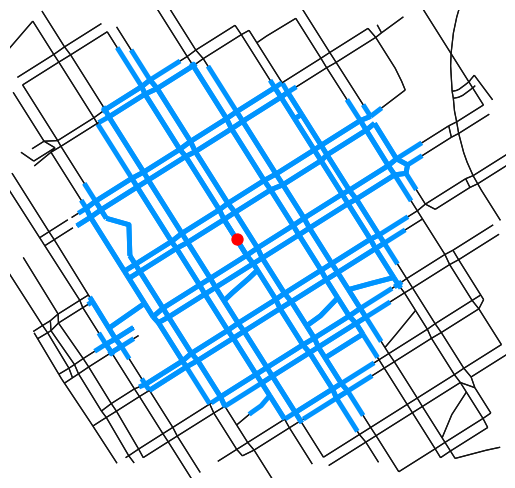

<ggplot: (8735773478906)>

In [9]:
plot = plot_walkshed("downtown", normative_cost_fun)
plot.save("../artifacts/figures/Fig3/figure_walksheds_downtown_normative.png", dpi=180)
plot.save("../artifacts/figures/Fig3/figure_walksheds_downtown_normative.svg", dpi=180)
plot

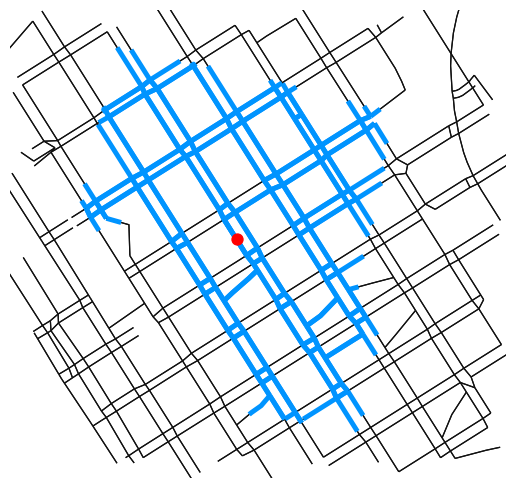

<ggplot: (8735769302833)>

In [10]:
plot = plot_walkshed("downtown", wheelchair_cost_fun)
plot.save("../artifacts/figures/Fig3/figure_walksheds_downtown_wheelchair.png", dpi=180)
plot.save("../artifacts/figures/Fig3/figure_walksheds_downtown_wheelchair.svg", dpi=180)
plot